# The Traveling Salesman Problem with Time Windows

The TSP with time windows is a variant of the TSP where all clients can only be visited in specific time intervals. The objective is to find a tour that minimizes the total travel time while respecting the time windows.

<img src="img/tsptw.png" alt="tsptw" style="width:500px; height:400px;">

In this notebook, we will show how to model and solve the TSPTW using SeaPearl.jl.

## Setup
We will begin by activating the environment and importing the necessary packages.

In [1]:
using Revise
using Pkg
Pkg.activate("../../../")
using SeaPearl

  Activating project at `c:\Users\leobo\Desktop\École\Poly\SeaPearl\SeaPearlZoo.jl`

## Instance

In this notebook, we will be using the following instance:

In [2]:
distances = [0 19 17 34 7 20 10 17 28 15 23 29 23 29 21 20 9 16 21 13 12;
19 0 10 41 26 3 27 25 15 17 17 14 18 48 17 6 21 14 17 13 31;
17 10 0 47 23 13 26 15 25 22 26 24 27 44 7 5 23 21 25 18 29;
34 41 47 0 36 39 25 51 36 24 27 38 25 44 54 45 25 28 26 28 27;
7 26 23 36 0 27 11 17 35 22 30 36 30 22 25 26 14 23 28 20 10;
20 3 13 39 27 0 26 27 12 15 14 11 15 49 20 9 20 11 14 11 30;
10 27 26 25 11 26 0 26 31 14 23 32 22 25 31 28 6 17 21 15 4;
17 25 15 51 17 27 26 0 39 31 38 38 38 34 13 20 26 31 36 28 27;
28 15 25 36 35 12 31 39 0 17 9 2 11 56 32 21 24 13 11 15 35;
15 17 22 24 22 15 14 31 17 0 9 18 8 39 29 21 8 4 7 4 18;
23 17 26 27 30 14 23 38 9 9 0 11 2 48 33 23 17 7 2 10 27;
29 14 24 38 36 11 32 38 2 18 11 0 13 57 31 20 25 14 13 17 36;
23 18 27 25 30 15 22 38 11 8 2 13 0 47 34 24 16 7 2 10 26;
29 48 44 44 22 49 25 34 56 39 48 57 47 0 46 48 31 42 46 40 21;
21 17 7 54 25 20 31 13 32 29 33 31 34 46 0 11 29 28 32 25 33;
20 6 5 45 26 9 28 20 21 21 23 20 24 48 11 0 23 19 22 17 32;
9 21 23 25 14 20 6 26 24 8 17 25 16 31 29 23 0 11 15 9 10;
16 14 21 28 23 11 17 31 13 4 7 14 7 42 28 19 11 0 5 3 21;
21 17 25 26 28 14 21 36 11 7 2 13 2 46 32 22 15 5 0 8 25;
13 13 18 28 20 11 15 28 15 4 10 17 10 40 25 17 9 3 8 0 19;
12 31 29 27 10 30 4 27 35 18 27 36 26 21 33 32 10 21 25 19 0]

time_windows = [0         408;
62        68;
181       205;
306       324;
214       217;
51        61;
102       129;
175       186;
250       263;
3         23;
21        49;
79        90;
78        96;
140       154;
354       386;
42        63;
2         13;
24        42;
20        33;
9         21;
275       300]


21×2 Matrix{Int64}:
   0  408
  62   68
 181  205
 306  324
 214  217
  51   61
 102  129
 175  186
 250  263
   3   23
   ⋮  
  78   96
 140  154
 354  386
  42   63
   2   13
  24   42
  20   33
   9   21
 275  300

## Modeling the Problem

We will now build a model for the problem

In [6]:
struct TsptwVariableSelection{TakeObjective} <: SeaPearl.AbstractVariableSelection{TakeObjective} end

TsptwVariableSelection(; take_objective=false) = TsptwVariableSelection{take_objective}()
"""
    TsptwVariableSelection(cpmodel::SeaPearl.CPModel; rng=nothing)
Selects the first unbound variable.
"""
function (::TsptwVariableSelection{false})(cpmodel::SeaPearl.CPModel; rng=nothing)
    for i in 1:length(keys(cpmodel.variables))
        if haskey(cpmodel.variables, "a_" * string(i)) && !SeaPearl.isbound(cpmodel.variables["a_"*string(i)])
            return cpmodel.variables["a_"*string(i)]
        end
    end
    println(cpmodel.variables)
end

"""
    closest_city(x::SeaPearl.IntVar, dist::Matrix, model::SeaPearl.CPModel)
Value selection heuristic where the closest city is chosen.
"""
function closest_city(x::SeaPearl.IntVar, dist::Matrix, model::SeaPearl.CPModel)
    i = 1
    while "a_" * string(i) != x.id
        i += 1
    end
    current_city = SeaPearl.assignedValue(model.variables["v_"*string(i)])
    j = 0
    minDist = 0
    closer = j
    found_one = false
    while j < size(dist, 1)
        j += 1
        if (!found_one || dist[current_city, j] < minDist) && j in x.domain
            minDist = dist[current_city, j]
            closer = j
            found_one = true
        end
    end
    return closer
end

closest_city

In [7]:
trailer = SeaPearl.Trailer()
model = SeaPearl.CPModel(trailer)

n_city = size(distances)[1]
grid_size = 100
max_tw_gap = 10
max_tw = 100

generator = SeaPearl.TsptwGenerator(n_city, grid_size, max_tw_gap, max_tw)
dist, time_windows = SeaPearl.fill_with_generator!(model, generator; dist=distances, timeWindows=time_windows)

variableheuristic = TsptwVariableSelection{false}()
my_heuristic(x::SeaPearl.IntVar) = minimum(x.domain)
valueheuristic = SeaPearl.BasicHeuristic((x; cpmodel=nothing) -> closest_city(x, dist, model))

SeaPearl.BasicHeuristic(var"#11#13"(), nothing)

## Solving the Problem

The model is built; let's solve it!

In [8]:
variableheuristic = TsptwVariableSelection{false}()
valueheuristic = SeaPearl.BasicHeuristic((x; cpmodel = nothing) -> closest_city(x, dist, model))
SeaPearl.solve!(model; variableHeuristic=variableheuristic, valueSelection=valueheuristic)

:Optimal

## Visualizing the Solution

Let's visualize the solution obtained

In [34]:
function get_best_solution(model::SeaPearl.CPModel)
    best_solution = nothing
    best_objective = Inf
    for solution in model.statistics.solutions
        if !isnothing(solution) && solution["total_cost"] < best_objective
            best_solution = solution
            best_objective = solution["total_cost"]
        end
    end
    return best_solution
end

function get_solution_tour(model::SeaPearl.CPModel, num_cities=size(distances)[1])
    best_solution = get_best_solution(model)
    tour = zeros(Int, num_cities)
    for (k, v) in best_solution
        if occursin("a_", k)
            customer_id = parse(Int, split(k, "_")[2])
            tour[v] = customer_id
        end
    end
    return tour
end

best_solution = get_best_solution(model)
tour = get_solution_tour(model)

21-element Vector{Int64}:
  0
  9
 15
 19
 16
  7
 12
 14
 17
  2
  ⋮
 11
 13
 20
  8
  1
  4
  5
  3
 18

In [35]:
tour

21-element Vector{Int64}:
  0
  9
 15
 19
 16
  7
 12
 14
 17
  2
  ⋮
 11
 13
 20
  8
  1
  4
  5
  3
 18

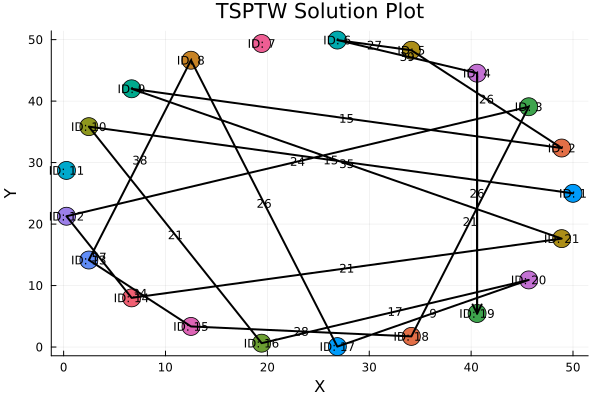

In [56]:
using Plots, Random

# Set the radius and center of the circle
radius = 25
center = [25, 25]

# Calculate coordinates in a circle
theta = range(0, stop=2pi, length=22)  # We use 22 to get 21 evenly spaced points (the 22nd point will overlap with the 1st one)
coordinates = hcat([center[1] + radius * cos(t) for t in theta],
    [center[2] + radius * sin(t) for t in theta])

# Remove the last point to have 21 unique points
coordinates = coordinates[1:21, :]
customers = 1:21

# Your distance matrix
# Your tour array
tour = [0, 9, 15, 19, 16, 7, 12, 14, 17, 2, 11, 13, 20, 8, 1, 4, 5, 3, 18] 

# Add one to all tour indices because Julia arrays are 1-indexed
tour .+= 1

scatter(coordinates[:,1], coordinates[:,2], 
    markersize = 10,  # Scale down the size for visibility
    markercolor = customers,  # Color represents customer ID
    legend = false,
    xlabel = "X",
    ylabel = "Y",
    title = "TSPTW Solution Plot")

# Annotate each point with customer ID and time window
for (idx, (x, y)) in enumerate(eachrow(coordinates))
    annotate!(x, y, text("ID: $idx", 8))
end

# Now we can draw the tour.
tour_coordinates = coordinates[tour, :]  # Adjusted indices


# Now add edge labels
for i in 1:(length(tour) - 1)
    x1, y1 = coordinates[tour[i], :]
    x2, y2 = coordinates[tour[i + 1], :]
    distance = distances[tour[i], tour[i + 1]]  # Fetch the distance from the distance matrix
    annotate!((x1 + x2) / 2, (y1 + y2) / 2, text("$distance", 8, :black))
end
plot!(tour_coordinates[:, 1], tour_coordinates[:, 2], arrow=true, linecolor=:black, linewidth=2)